In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
from IPython.core.display import clear_output, display
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df, get_pd_line_graph, \
    apply_nodes_restrictions, apply_edge_restriction, construct_output_graph
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


C:\Miniconda3\envs\ariadne_gpu\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
from prepare import parse

csv_params = {
"sep": '\s+',
"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0']
}
suff_df = ('_p', '_c')
gin.bind_parameter('get_pd_line_graph.restrictions_0',(-0.2, 0.2))
gin.bind_parameter('get_pd_line_graph.restrictions_1', (-0.28, 0.28))
gin.bind_parameter('get_pd_line_graph.suffix_c', '_c')
gin.bind_parameter('get_pd_line_graph.suffix_p','_p')
gin.bind_parameter('get_supernodes_df.suffix_c', '_c')
gin.bind_parameter('get_supernodes_df.suffix_p', '_p')
gin.bind_parameter('get_supernodes_df.axes', ['r', 'phi', 'z'])
gin.bind_parameter('apply_edge_restriction.edge_restriction', 0.093)
stations_constraints = {
    0: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    1: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    2: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
}

In [3]:
events = parse("../data/new_data/1.txt", csv_params=csv_params, events_quantity='0..300')
events = next(events)[0]
events_to_analyze = events[events.event < 300]

In [4]:
from collections import namedtuple
GraphWithIndices = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y', 'v', 'v_from_to','e_from_to' ])

def construct_graph_with_indices(graph, v_inds, v_from_to, e_from_to):
    return GraphWithIndices(graph.X, graph.Ri, graph.Ro, graph.y, v_inds, v_from_to, e_from_to)

In [5]:
nodes = pd.DataFrame()
edges = pd.DataFrame()

graphs = []

for idx, event in events_to_analyze.groupby('event'):
    clear_output(wait=True)
    display("Event #%09d" % idx)

    transformer = Compose([
            ConstraintsNormalize(
                use_global_constraints=False,
                constraints=stations_constraints
            ),
            ToCylindrical(drop_old=True, cart_columns=('y', 'x'))
        ])
    try:
        event = transformer(event)
    except AssertionError as err:
        print("ASS error %r" % err)
        continue
    G = to_pandas_graph_from_df(event, suffixes=suff_df, compute_is_true_track=True)
    nodes_t, edges_t = get_pd_line_graph(G, apply_nodes_restrictions)
    edges_filtered = apply_edge_restriction(edges_t)
    graph = construct_output_graph(nodes_t, edges_filtered, ['y_p', 'y_c', 'z_p', 'z_c', 'z'],
                                     [np.pi, np.pi, 1., 1., 1.], 'edge_index_p', 'edge_index_c')
    graph_with_inds = construct_graph_with_indices(graph, 
                                                   nodes_t.index.values, 
                                                   nodes_t[['from_ind','to_ind']].values,
                                                   edges_filtered[['edge_index_p','edge_index_c']].values)
    np.testing.assert_allclose(graph_with_inds.X, nodes_t[['y_p', 'y_c', 'z_p', 'z_c', 'z']].values/[np.pi, np.pi, 1., 1., 1.])
    graphs.append(graph_with_inds)
    
    

'Event #000000298'

In [6]:
len(graphs)

261

In [7]:
from ariadne.graph_net.model import GraphNet_v1
import torch

gin.bind_parameter('GraphNet_v1.input_dim', 5)
gin.bind_parameter('GraphNet_v1.hidden_dim', 128)
gin.bind_parameter('GraphNet_v1.n_iters', 1)

def weights_update(model, checkpoint):
    model_dict = model.state_dict()    
    pretrained_dict =  checkpoint['state_dict']
    real_dict = {}
    for (k,v) in model_dict.items():
        needed_key = None
        for pretr_key in pretrained_dict:
            if k in pretr_key:
                needed_key = pretr_key
                break
        assert needed_key is not None, "key %s not in pretrained_dict %r!" % (k, pretrained_dict.keys())
        real_dict[k] = pretrained_dict[needed_key]

    model.load_state_dict(real_dict)
    model.eval()
    return model

model = weights_update(model=GraphNet_v1(), checkpoint=torch.load('../lightning_logs/version_hydra_63115/checkpoints/epoch=49.ckpt'))


In [8]:
from ariadne.graph_net.dataset import GraphDatasetFromMemory, collate_fn
from ariadne.graph_net.data_loader import GraphDataLoader

gin.bind_parameter('GraphDatasetFromMemory.input_graphs', graphs)

data_loader = GraphDataLoader(
    batch_size=1,
    dataset=GraphDatasetFromMemory,
    collate_fn=collate_fn,
    n_train=0,
    n_valid=len(graphs)-1    
).get_val_dataloader()

In [9]:
with torch.no_grad():
    test_outputs = [(model(batch_input).flatten(), batch_target.flatten())
                    for (batch_input, batch_target) in data_loader]
    test_pred, test_target = zip(*test_outputs)
    test_pred = np.concatenate(test_pred)
    test_target = np.concatenate(test_target)


In [10]:
import sklearn.metrics
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.5
Accuracy:  0.9787
Precision: 0.9111
Recall:    0.9619


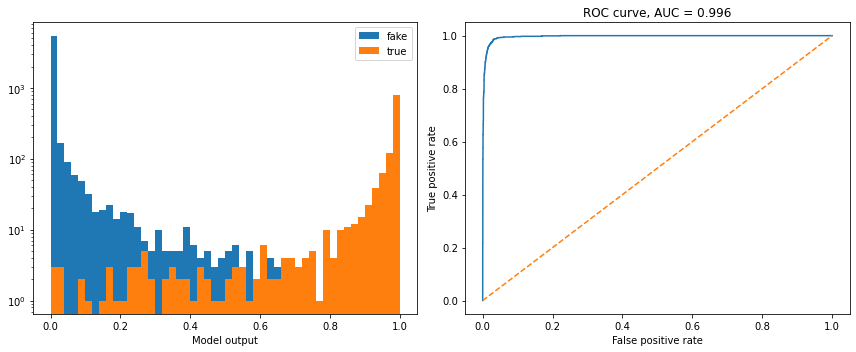

In [11]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the model outputs
binning=dict(bins=50, range=(0,1), histtype='bar', log=True)
ax0.hist(test_pred[y_true==False], label='fake', **binning)
ax0.hist(test_pred[y_true], label='true', **binning)
ax0.set_xlabel('Model output')
ax0.legend(loc=0)

# Plot the ROC curve
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve, AUC = %.3f' % auc)

plt.tight_layout()

In [12]:
def draw_single(X, Ri, Ro, y, c_true = 'green', c_fake = (0,0,0,0.1), xcord1 = (2, 'x'), xcord2 = (1, 'y'), ycord=(0, 'z'), draw_fake=True):
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    #                0    1  2  3  4  5
    # Draw the hits (r, phi, z, x, y, z)
    # colMap = np.zeros_like(X)
    # colMap[:, 0] = X[:, 0]*1.7 + 100
    # colMap *= 1.0 / colMap.max()
    ax0.scatter(X[:, xcord1[0]],
                X[:, ycord[0]], c='black')
    ax1.scatter(X[:, xcord2[0]],
                X[:, ycord[0]], c='black')

    # Draw the segments
    for j in range(y.shape[0]):
        ax0.plot([feats_o[j, xcord1[0]], feats_i[j, xcord1[0]]],
                 [feats_o[j, ycord[0]], feats_i[j, ycord[0]]], '-', c=c_true if y[j] > 0.5 else c_fake, zorder=10 if y[j] > 0.5 else 1)
        ax1.plot([feats_o[j, xcord2[0]], feats_i[j, xcord2[0]]],
                 [feats_o[j, ycord[0]], feats_i[j, ycord[0]]], '-', c=c_true if y[j] > 0.5 else c_fake, zorder=10 if y[j] > 0.5 else 1)
    # Adjust axes
    ax0.set_xlabel('$%s$' % xcord1[1])
    ax0.set_ylabel('$%s$' % ycord[1])

    ax1.set_xlabel('$%s$' % xcord2[1])
    ax1.set_ylabel('$%s$' % ycord[1])
    plt.tight_layout()
    plt.show()

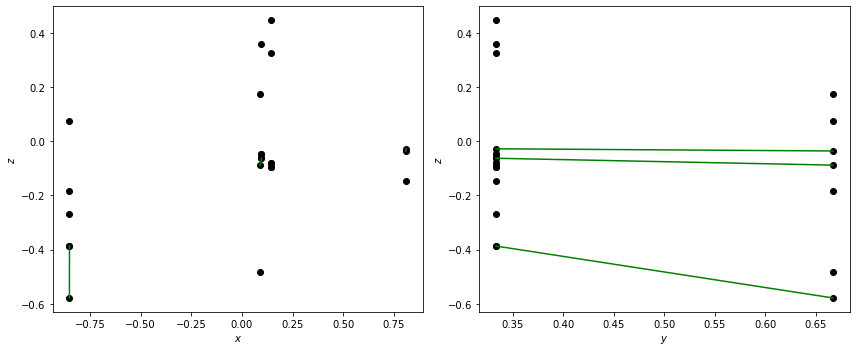

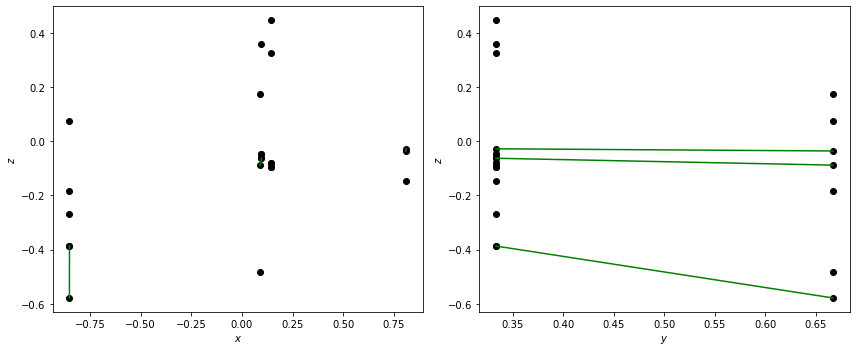

In [13]:

n_draw = 123

X, Ri, Ro, y = data_loader.dataset[n_draw]
pred = test_outputs[n_draw][0].numpy()
draw_single(X, Ri, Ro, pred, c_fake=(0,0,0,0.0), xcord1=(0, 'x'), xcord2=(4, 'y'), ycord=(2, 'z'))
draw_single(X, Ri, Ro, y, c_fake=(0,0,0,0.0), xcord1=(0, 'x'), xcord2=(4, 'y'), ycord=(2, 'z'))
